Created with help from "An End-to-End Project on Time Series Analysis and Forecasting with Python"
https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

# Data Preprocessing

## Import Packages and Load Data

In [11]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [20]:
food = pd.read_csv('Data/food.csv')
food = food.loc[food['Category'] == 'Food & Drinks']
food.replace(',', '',regex=True, inplace=True)

In [21]:
income = pd.read_csv('Data/income.csv')
income = income.loc[income['Category'] == 'Income']
income.replace(',', '',regex=True, inplace=True)

In [22]:
debt = pd.read_csv('Data/debt.csv')
debt = debt.loc[debt['Category'] == 'Debt']
debt.replace(',', '',regex=True, inplace=True)

### Verify that everything loaded properly

In [23]:
food.head()

,Date,Category,Sub-category,Amount
0,2023-01-01,Food & Drinks,Drinks,-200.00
1,2023-01-01,Food & Drinks,Take-out,-40.45
2,2023-01-02,Food & Drinks,Coffee,-5.74
3,2023-01-03,Food & Drinks,NOCHARGE,0.00
4,2023-01-04,Food & Drinks,NOCHARGE,0.00


In [24]:
income.head()

,Date,Category,Sub-category,Amount
0,2023-01-01,Income,NOCHARGE,0.0
1,2023-01-02,Income,NOCHARGE,0.0
2,2023-01-03,Income,NOCHARGE,0.0
3,2023-01-04,Income,NOCHARGE,0.0
4,2023-01-05,Income,NOCHARGE,0.0


In [25]:
debt.head()

,Date,Category,Sub-category,Amount
0,2023-01-01,Debt,NOCHARGE,0.0
1,2023-01-02,Debt,NOCHARGE,0.0
2,2023-01-03,Debt,NOCHARGE,0.0
3,2023-01-04,Debt,NOCHARGE,0.0
4,2023-01-05,Debt,NOCHARGE,0.0


## Prepare Dataframes for Time Series Analysis

Make sure that the amounts are of the type 'float' and that the dataframes are ordered by date

In [26]:
def prepare(df):
    cols = ['Category', 'Sub-category']
    df.drop(cols, axis=1, inplace=True)
    df.sort_values('Date', inplace=True)
    df = df.astype({'Amount': float})
    df = df.groupby('Date')['Amount'].sum().reset_index()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df

In [27]:
prep_food = prepare(food)
prep_income = prepare(income)
prep_debt = prepare(debt)

## Visualize the Time Series Data

Text(0.5, 1.0, 'Interest on Debt 2023')

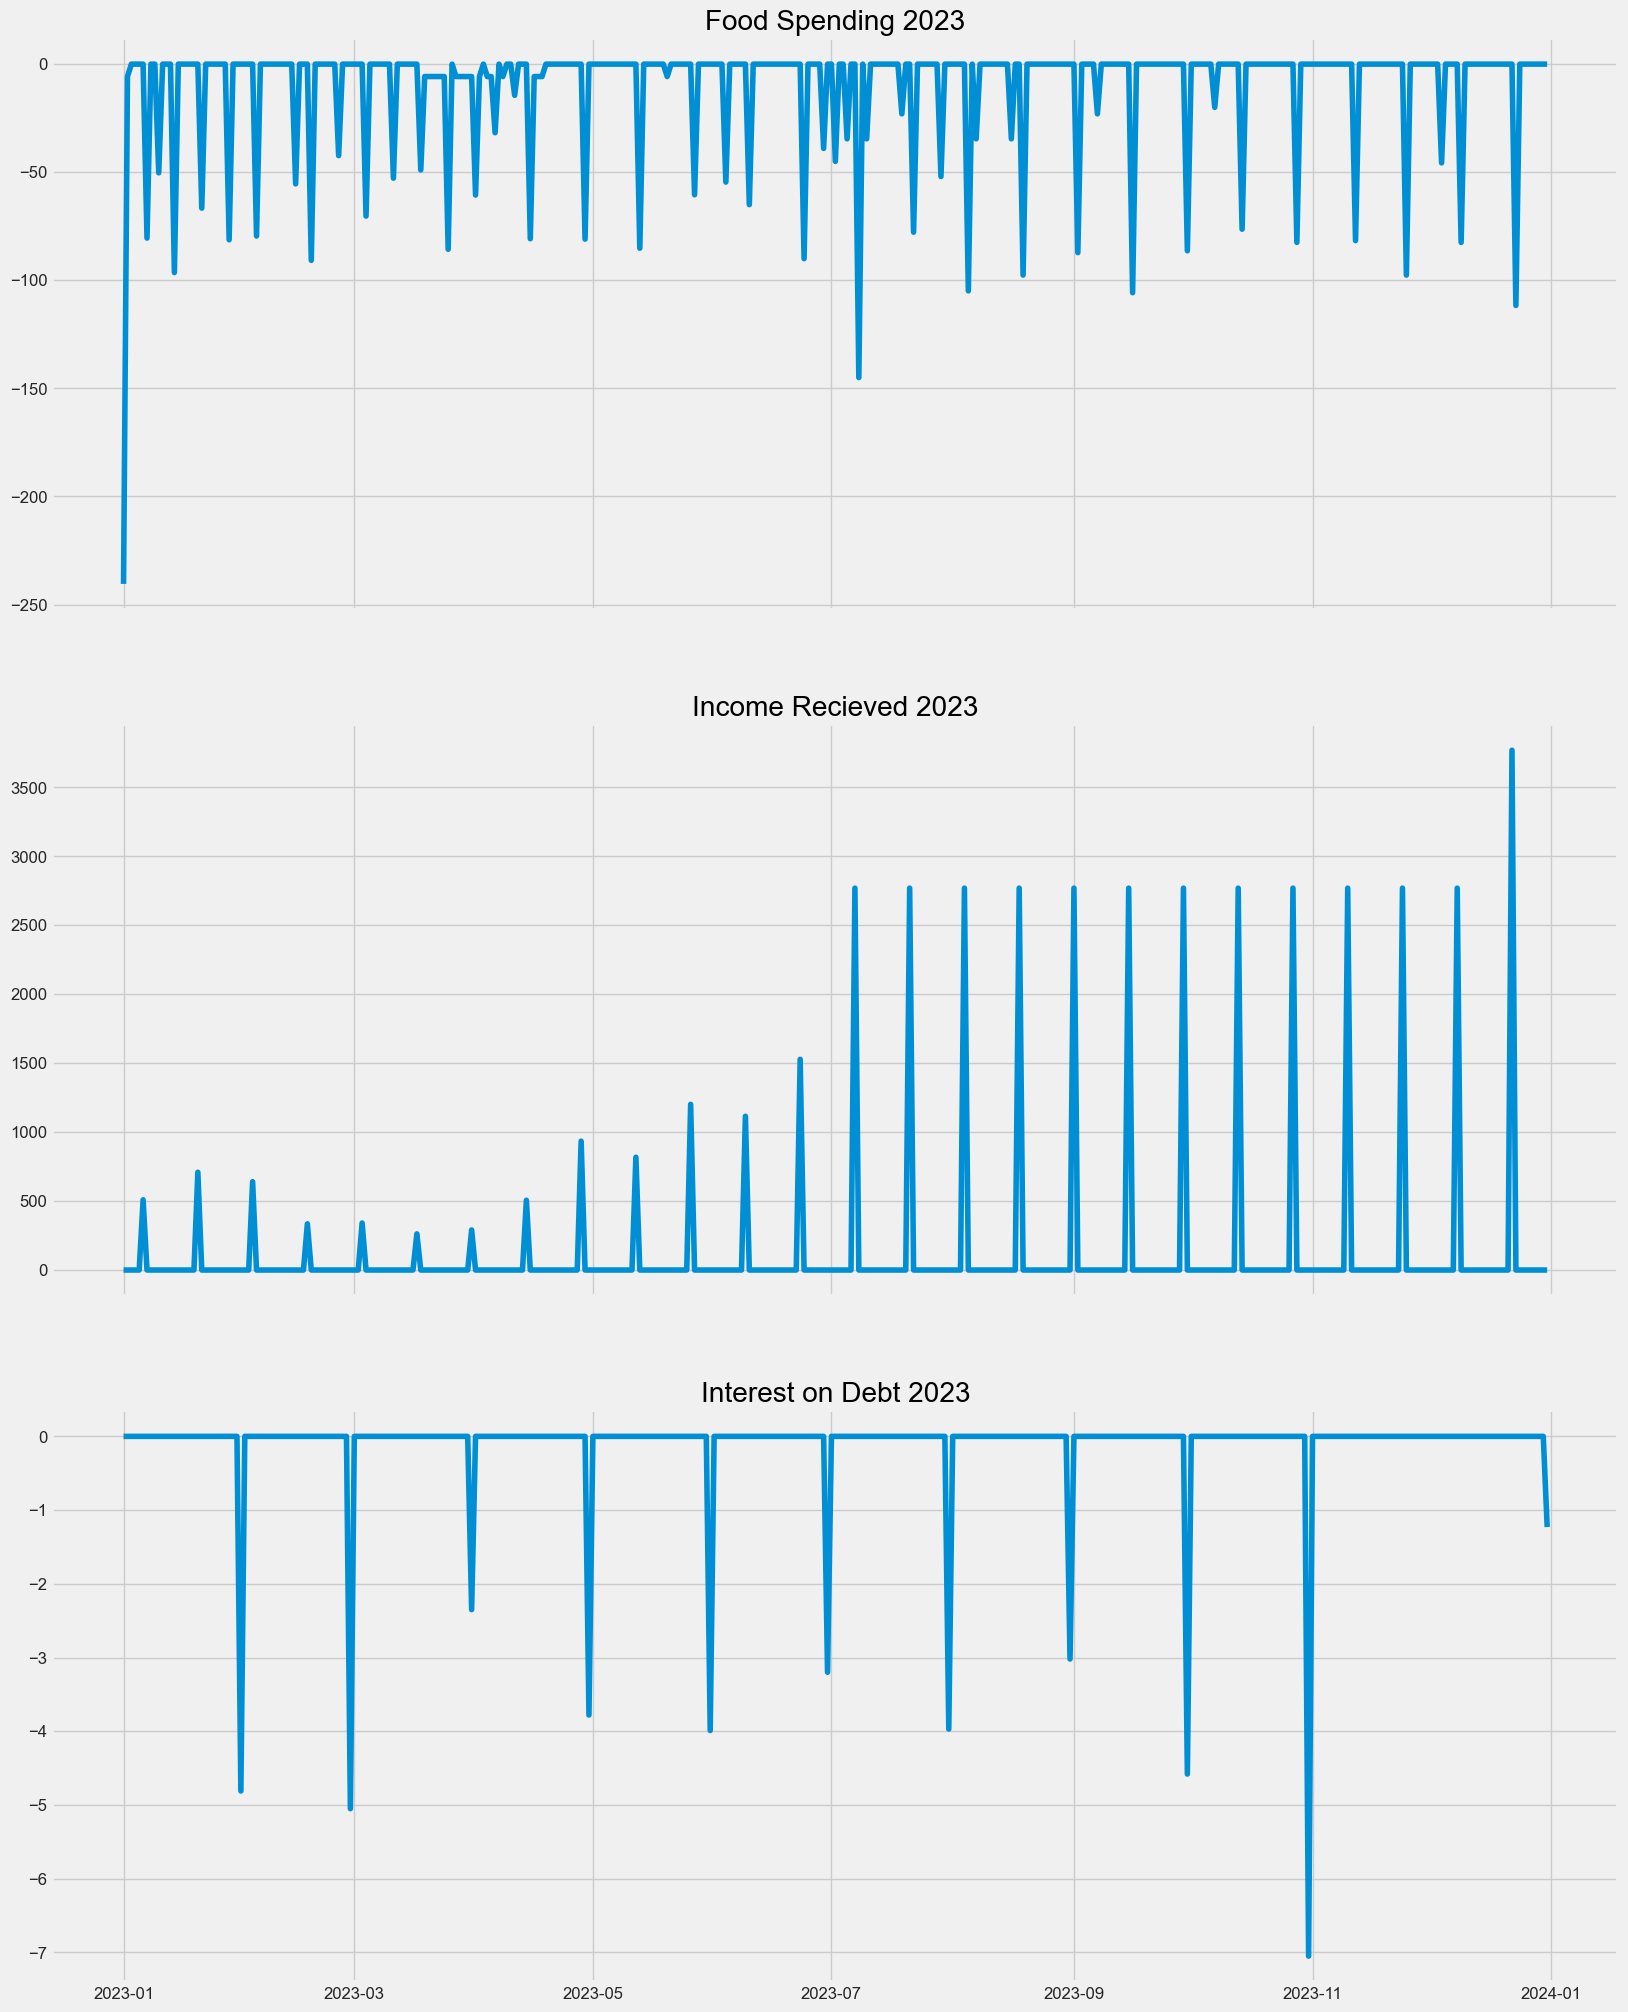

In [31]:
fig, axs = plt.subplots(3, sharex=True, figsize=(18,24))
axs[0].plot(prep_food['Amount'])
axs[0].set_title('Food Spending 2023')
axs[1].plot(prep_income['Amount'])
axs[1].set_title('Income Recieved 2023')
axs[2].plot(prep_debt['Amount'])
axs[2].set_title('Interest on Debt 2023')

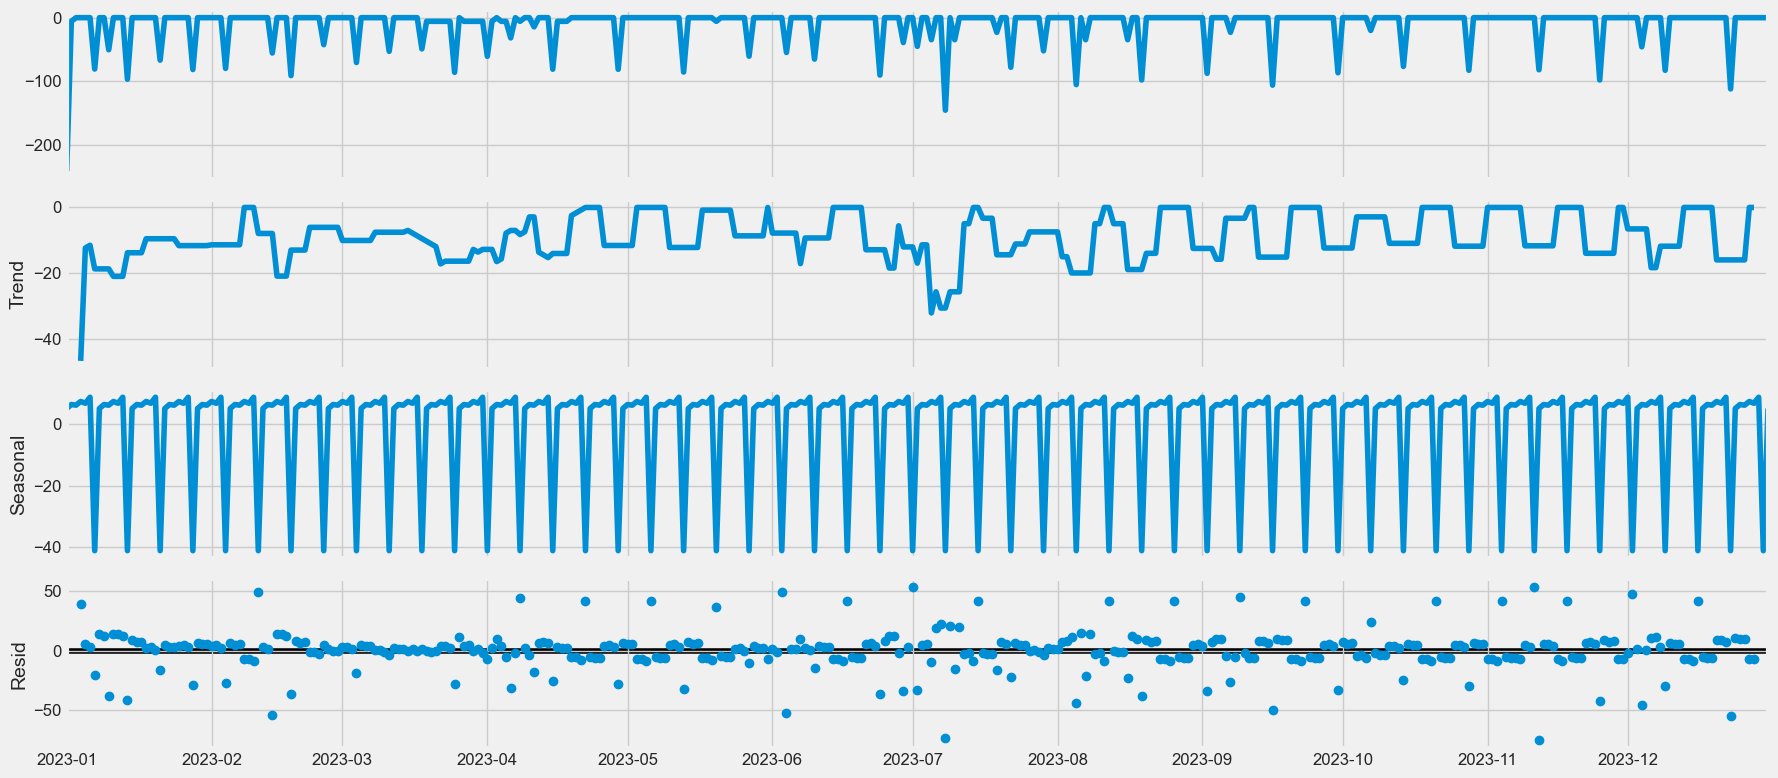

In [35]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

food_decomposition = sm.tsa.seasonal_decompose(prep_food, model='additive')
food_decomp_fig = food_decomposition.plot()
plt.show()

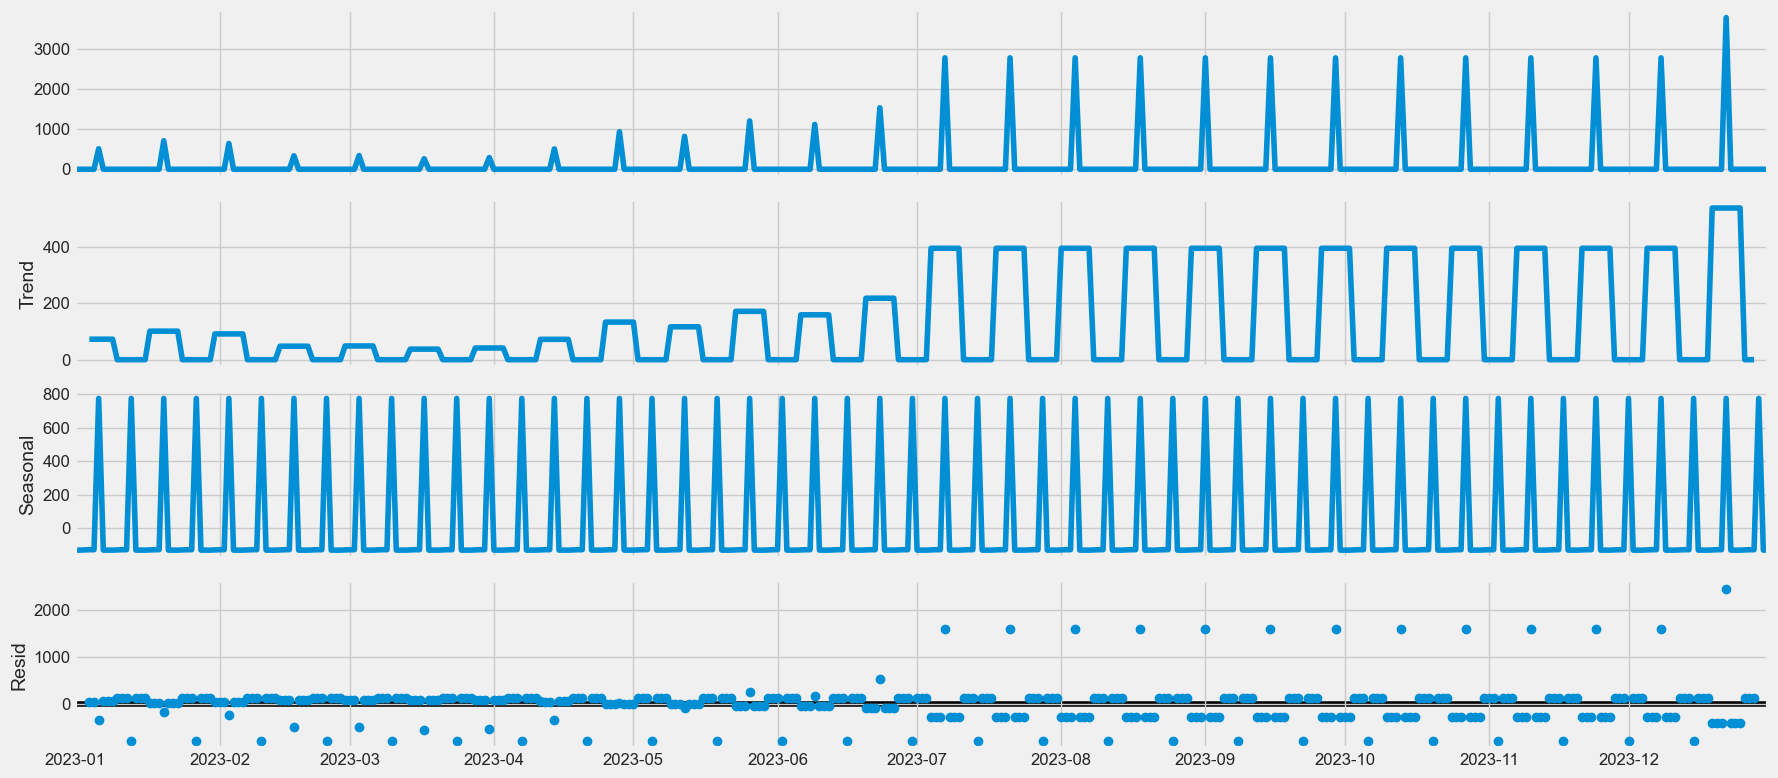

In [36]:
income_decomposition = sm.tsa.seasonal_decompose(prep_income, model='additive')
income_decomp_fig = income_decomposition.plot()
plt.show()

## **Error Below**

In [37]:
debt_decomposition = sm.tsa.seasonal_decompose(prep_debt, model='additive')
debt_decomp_fig = debt_decomposition.plot()
plt.show()

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

# Forecast using SARIMA (Seasonal Autoregressive Integrated Moving Average)
ARIMA is a combination of both Autoregressive and Moving Average methods
- Autoregressive assumes that the current value is a function of its past values
- Moving Average is commonly used to determine trend direction
    - Simple Moving Average: SMA = (A1 + A2 + ... An)/n, where An is the average in period n and n is the number of periods

## Find Optimal Set of SARIMA Parameters
p, d, and q account for seasonality, trend, and noise within the data
- p (Lag Order): the number of lag observations
- d (Degree of Differencing): number of times the raw observations are differenced
- q (Order of the Moving Average): size of the moving average window

In [38]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [150]:
def model_params(df):
    opti_params = None
    opti_seasonal_params = None
    aic = None
    model = None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = sm.tsa.statespace.SARIMAX(df, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
                params = model.fit()
                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, params.aic))
            except:
                continue
            
            if (aic is None) or (aic > params.aic):
                aic = params.aic
                opti_seasonal_params = param_seasonal
                opti_params = param
    return model, (opti_params, opti_seasonal_params)

In [151]:
unfit_food_model, food_params = model_params(prep_food)
unfit_income_model, income_params = model_params(prep_income)

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3409.0518616127915
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3296.730650954829
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3519.8023886221927
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3168.5277721451002
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3305.161365809737
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3298.519451039966
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:3323.250030415914
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3169.99586849995
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3402.608013527721
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3276.3775103220514
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:3501.7249987664313
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3157.736850354601
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:3307.159987500812
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:3278.3616359703037
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:3324.7741563634677
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:3158.2632402716
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:3648.58034524341
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:3521.6319920051565
ARIMA(

**Optimal Parameters for Food are (1, 0, 1) & (0, 1, 1, 12) with AIC: 3145**

In [65]:
food_params

((1, 0, 1), (0, 1, 1, 12))

## Fit the SARIMA Models

In [148]:
def fit_model(dataframe, params):
    model = sm.tsa.statespace.SARIMAX(dataframe, order=params[0], seasonal_order=params[1], enforce_stationarity=False, enforce_invertibility=False)
    return model.fit()

In [70]:
food_model = fit_model(prep_food, food_params)
income_model = fit_model(prep_income, income_params)

### Food Model Diagnostics

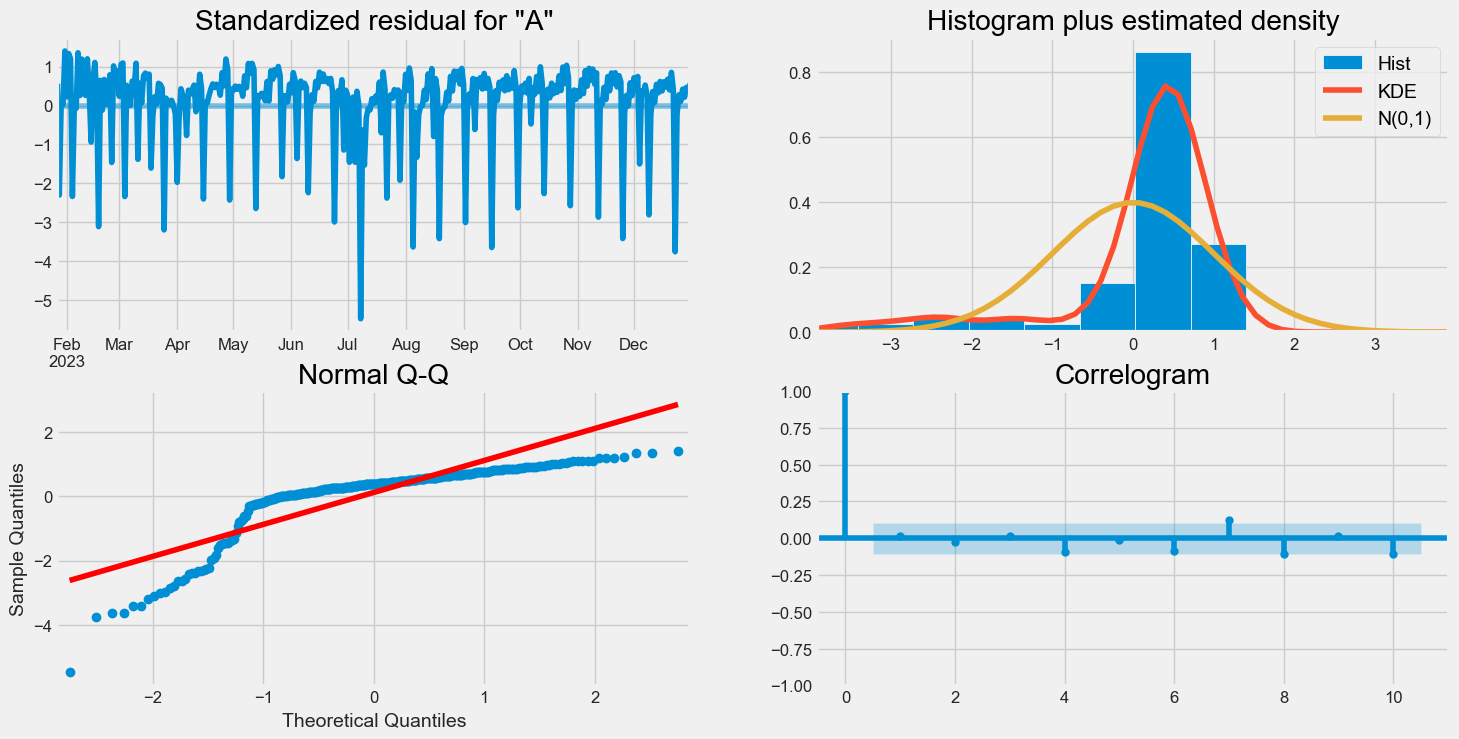

In [71]:
food_model.plot_diagnostics(figsize=(16, 8))
plt.show()

### Income Model Diagnostics

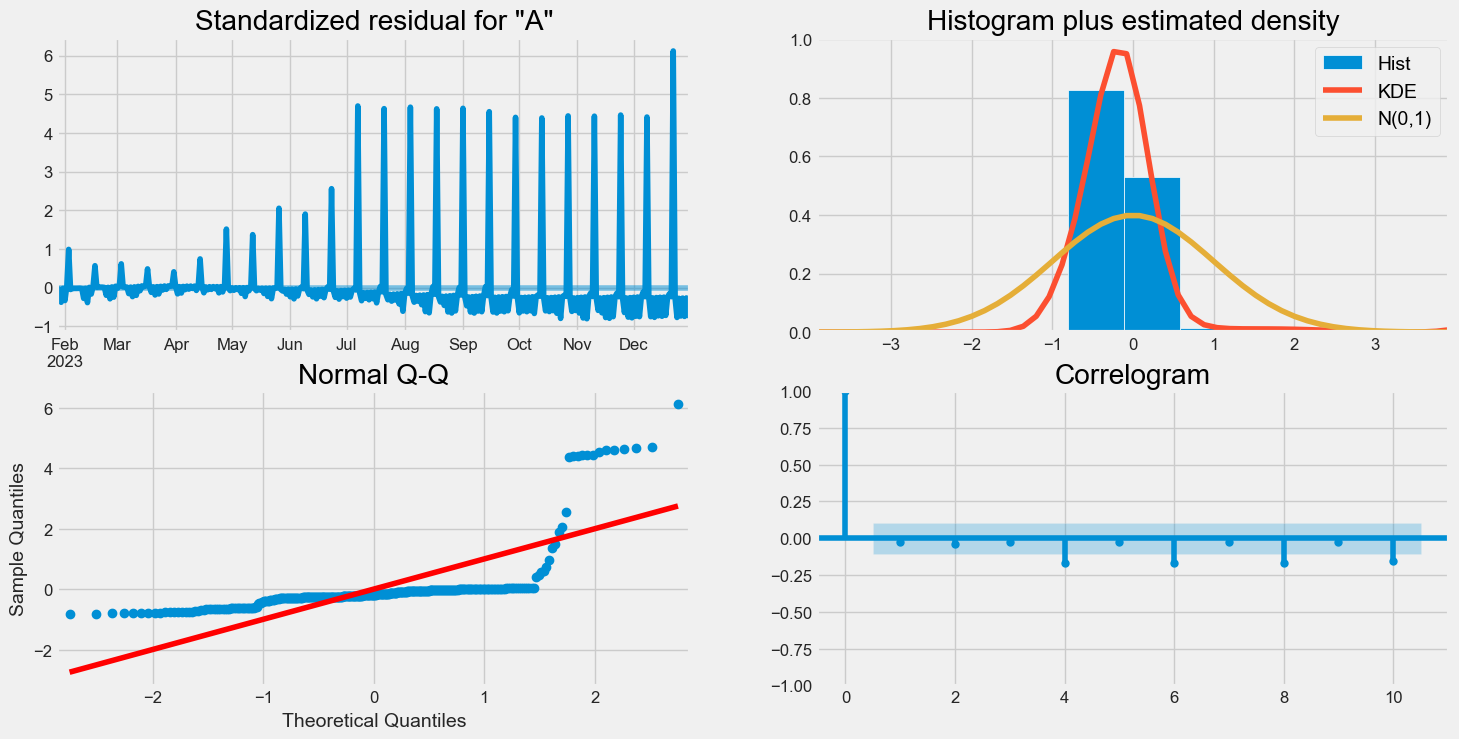

In [72]:
income_model.plot_diagnostics(figsize=(16, 8))
plt.show()

# Validating Forecasts

Enter the date in form of 'yyyy-mm-dd'

In [78]:
def predict(model, date, dataframe):
    pred = model.get_prediction(start=pd.to_datetime(date), dynamic=False)
    pred_ci = pred.conf_int()
    ax = dataframe['2023':].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Money')
    plt.legend()
    plt.show()
    return pred.predicted_mean

## Food

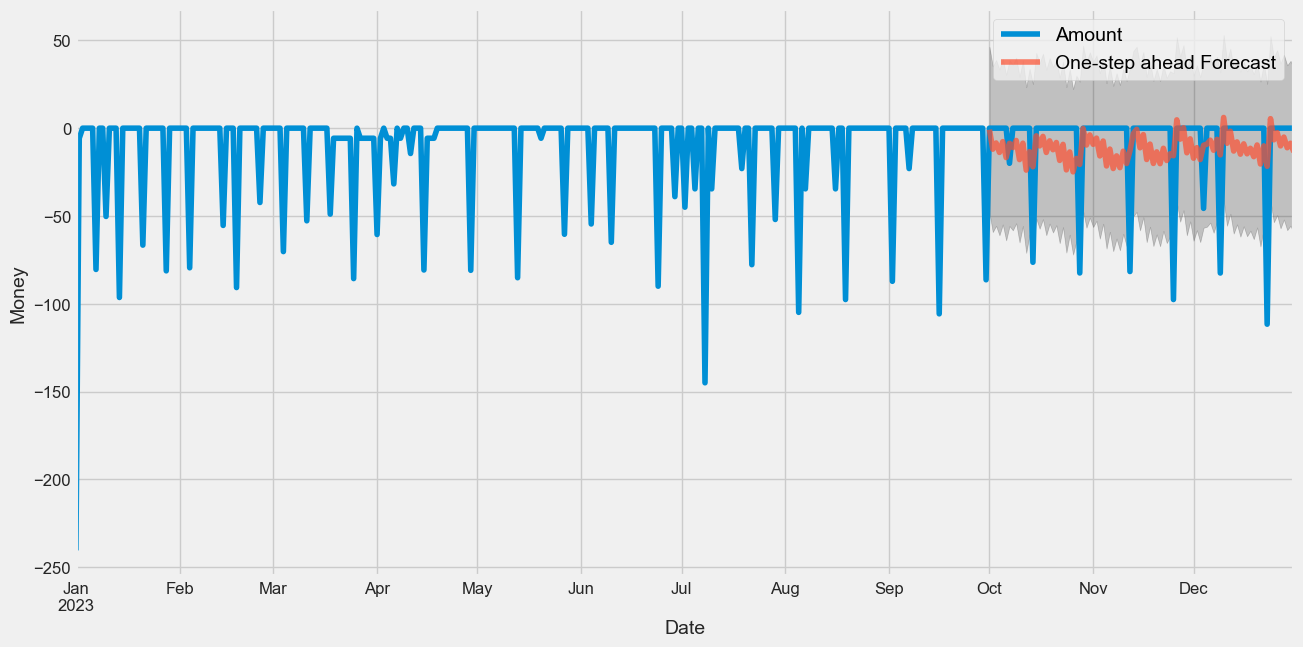

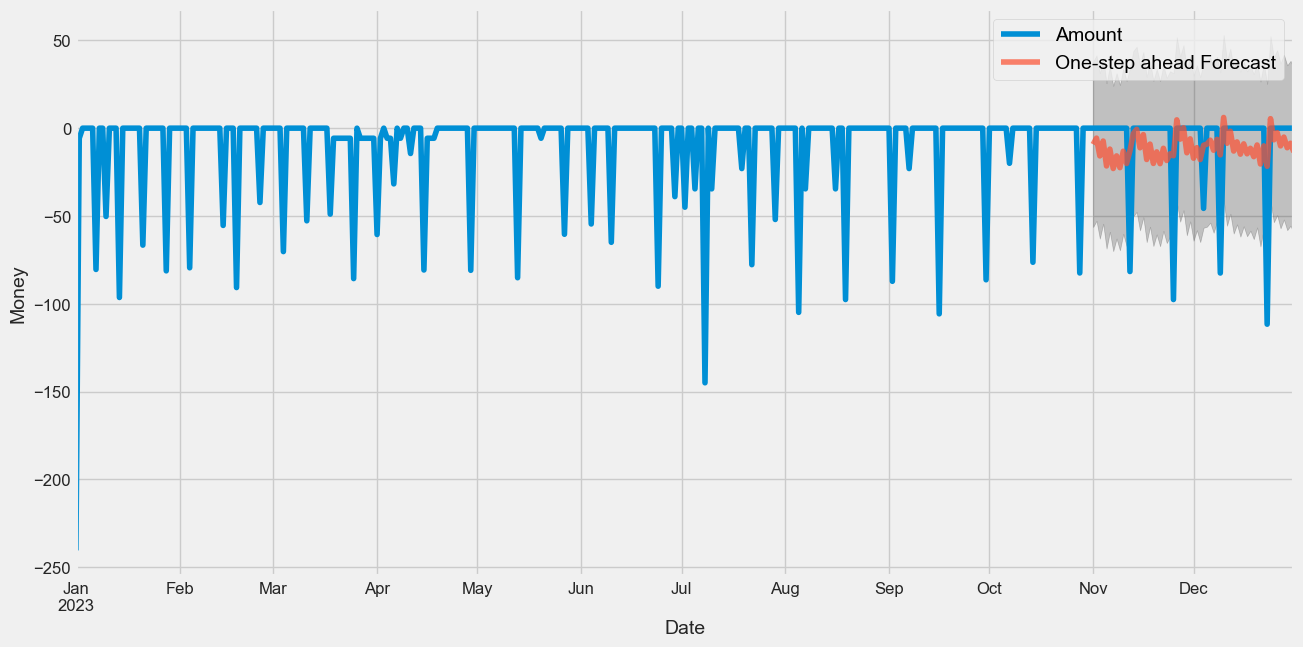

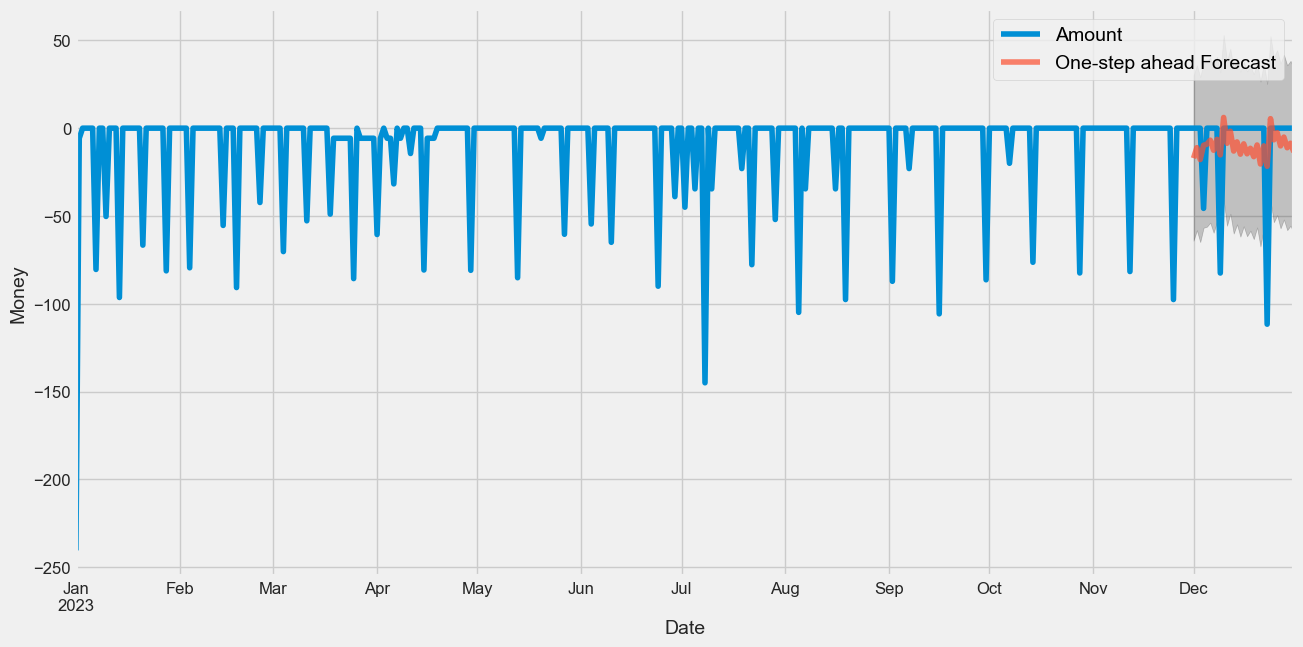

In [98]:
# October
oct_forecasted_food = predict(food_model, '2023-10-01', prep_food)
# November
nov_forecasted_food = predict(food_model, '2023-11-01', prep_food)
# December
dec_forecasted_food = predict(food_model, '2023-12-01', prep_food)

## Calculate the RMSE of each 

In [99]:
oct_actual_food = prep_food['2023-10-01':]
nov_actual_food = prep_food['2023-11-01':]
dec_actual_food = prep_food['2023-12-01':]

In [100]:
def rmse(actual, predicted):
    predicted = pd.DataFrame(predicted, columns=['predicted_mean'])
    predicted.rename(columns={'predicted_mean':'Amount'}, inplace=True)
    mse = (np.square(predicted['Amount'] - actual['Amount'])).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

In [101]:
# October
rmse(oct_actual_food, oct_forecasted_food)
# November
rmse(nov_actual_food, nov_forecasted_food)
# December
rmse(dec_actual_food, dec_forecasted_food)

The Mean Squared Error of our forecasts is 500.19
The Root Mean Squared Error of our forecasts is 22.36
The Mean Squared Error of our forecasts is 561.59
The Root Mean Squared Error of our forecasts is 23.7
The Mean Squared Error of our forecasts is 561.91
The Root Mean Squared Error of our forecasts is 23.7


## Income

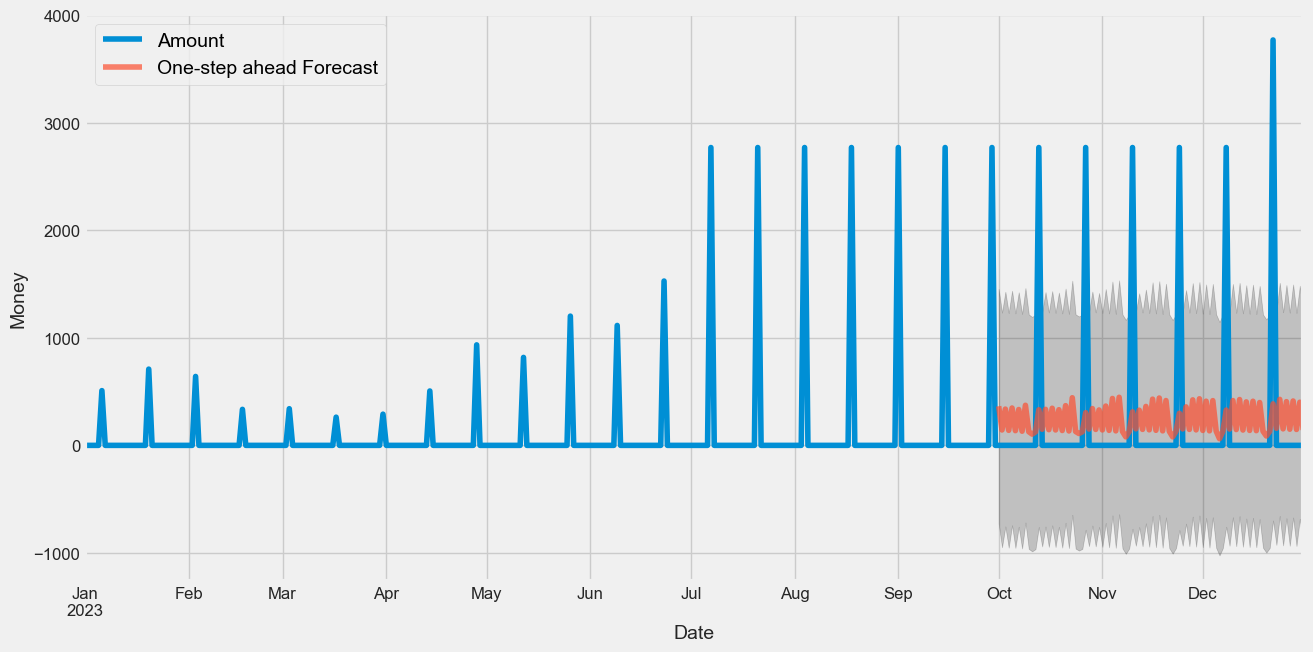

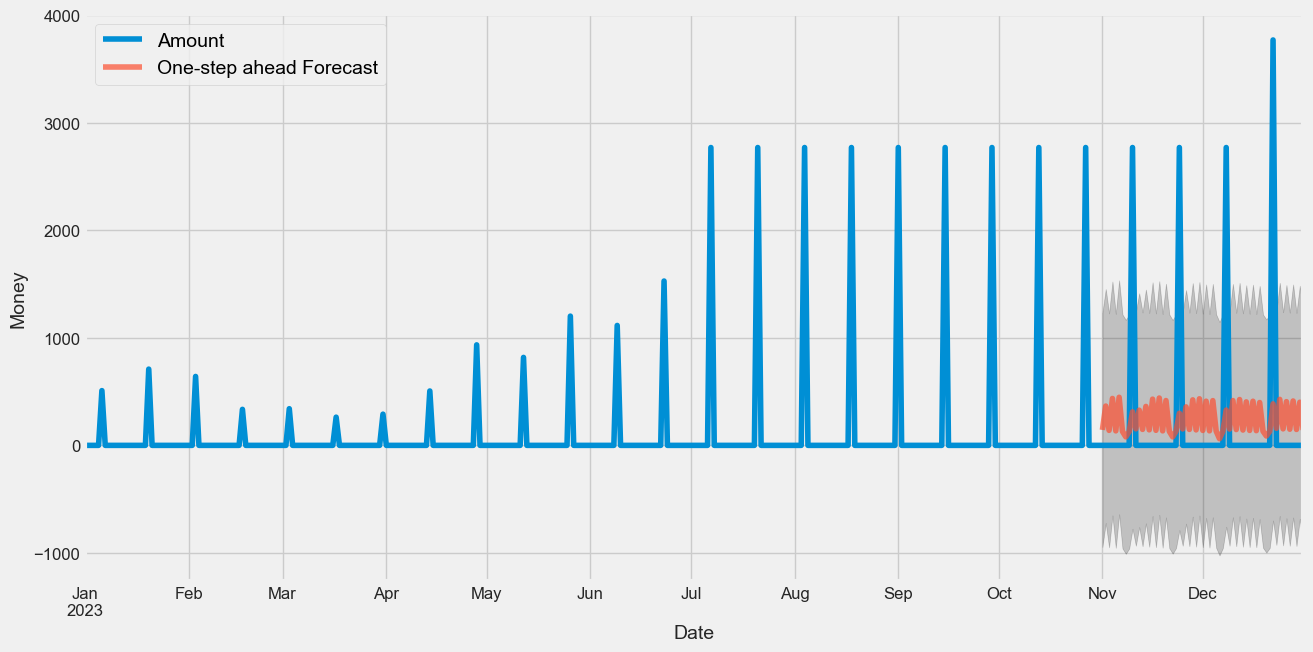

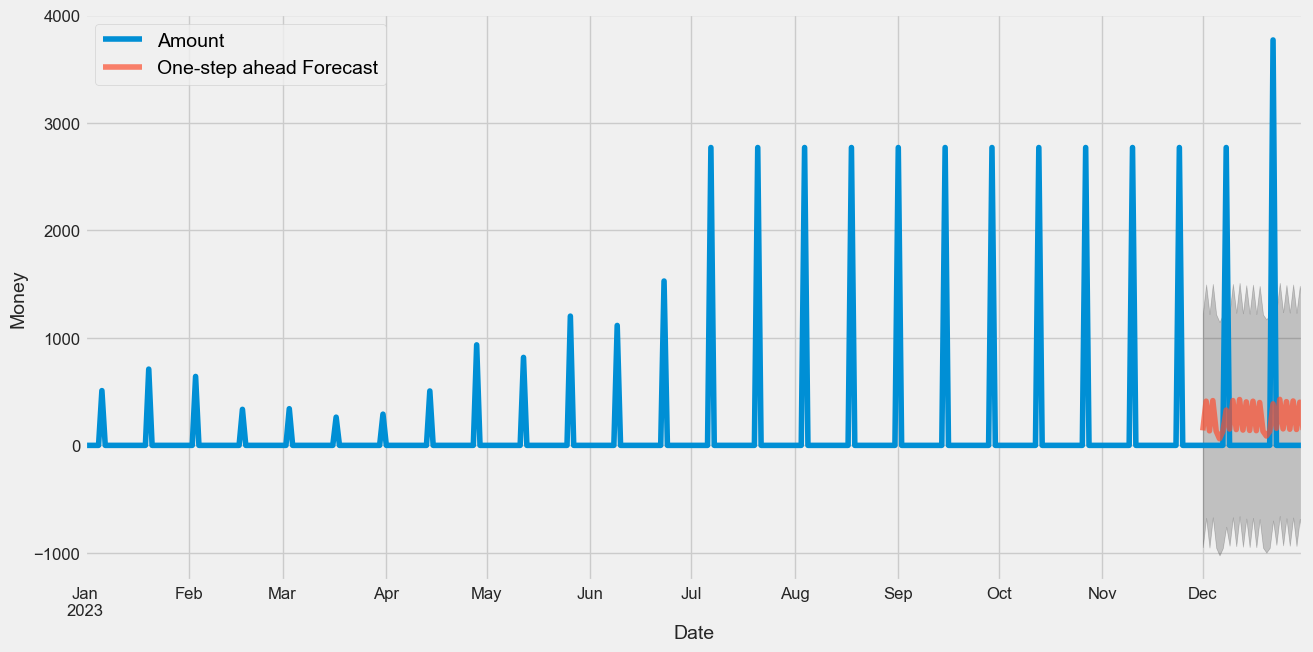

In [102]:
# October
oct_forecasted_income = predict(income_model, '2023-10-01', prep_income)
# November
nov_forecasted_income = predict(income_model, '2023-11-01', prep_income)
# December
dec_forecasted_income = predict(income_model, '2023-12-01', prep_income)

In [103]:
oct_actual_income = prep_income['2023-10-01':]
nov_actual_income = prep_income['2023-11-01':]
dec_actual_income = prep_income['2023-12-01':]

In [104]:
# October
rmse(oct_actual_income, oct_forecasted_income)
# November
rmse(nov_actual_income, nov_forecasted_income)
# December
rmse(dec_actual_income, dec_forecasted_income)

The Mean Squared Error of our forecasts is 518658.03
The Root Mean Squared Error of our forecasts is 720.18
The Mean Squared Error of our forecasts is 555211.13
The Root Mean Squared Error of our forecasts is 745.12
The Mean Squared Error of our forecasts is 632419.04
The Root Mean Squared Error of our forecasts is 795.25


# Producing and Visualizing the Forecasts

In [105]:
def forecast(dataframe, model):
    pred_uc = model.get_forecast(steps=32)
    pred_ci = pred_uc.conf_int()
    ax = dataframe.plot(label='observed', figsize=(14, 7))
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Money')
    plt.legend()
    plt.show()

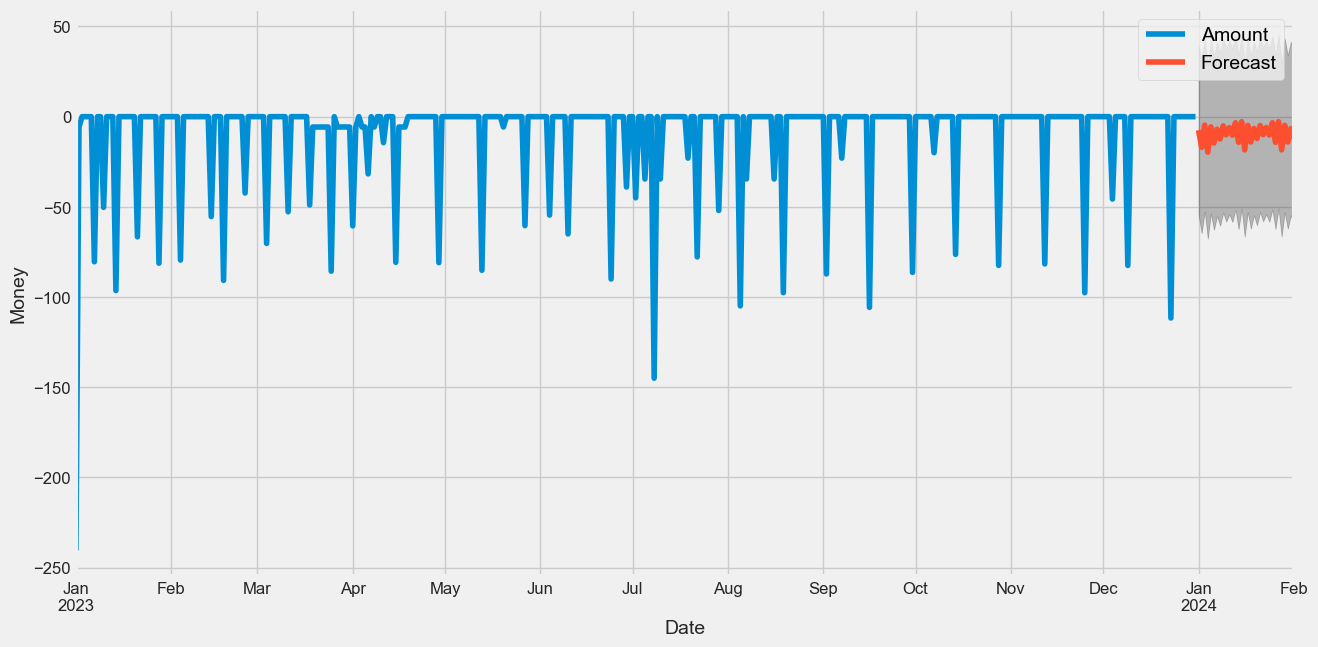

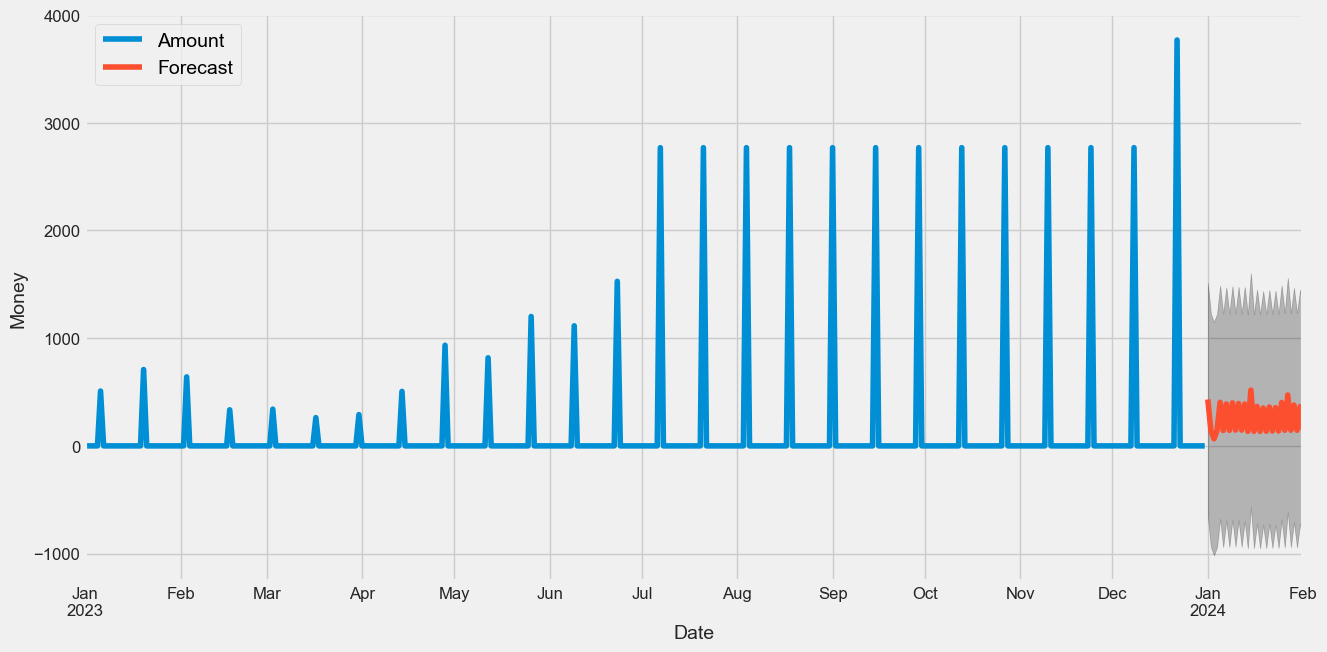

In [107]:
forecast(prep_food, food_model)
forecast(prep_income, income_model)

# Understanding p, d, and q

# q value

In [134]:
q_food_model1 = fit_model(prep_food, ((0, 0, 0), (1, 1, 0, 12)))
q_food_model2 = fit_model(prep_food, ((0, 0, 1), (1, 1, 0, 12)))
q_food_model3 = fit_model(prep_food, ((1, 0, 0), (1, 1, 0, 12)))
q_food_model4 = fit_model(prep_food, ((1, 0, 1), (1, 1, 0, 12)))

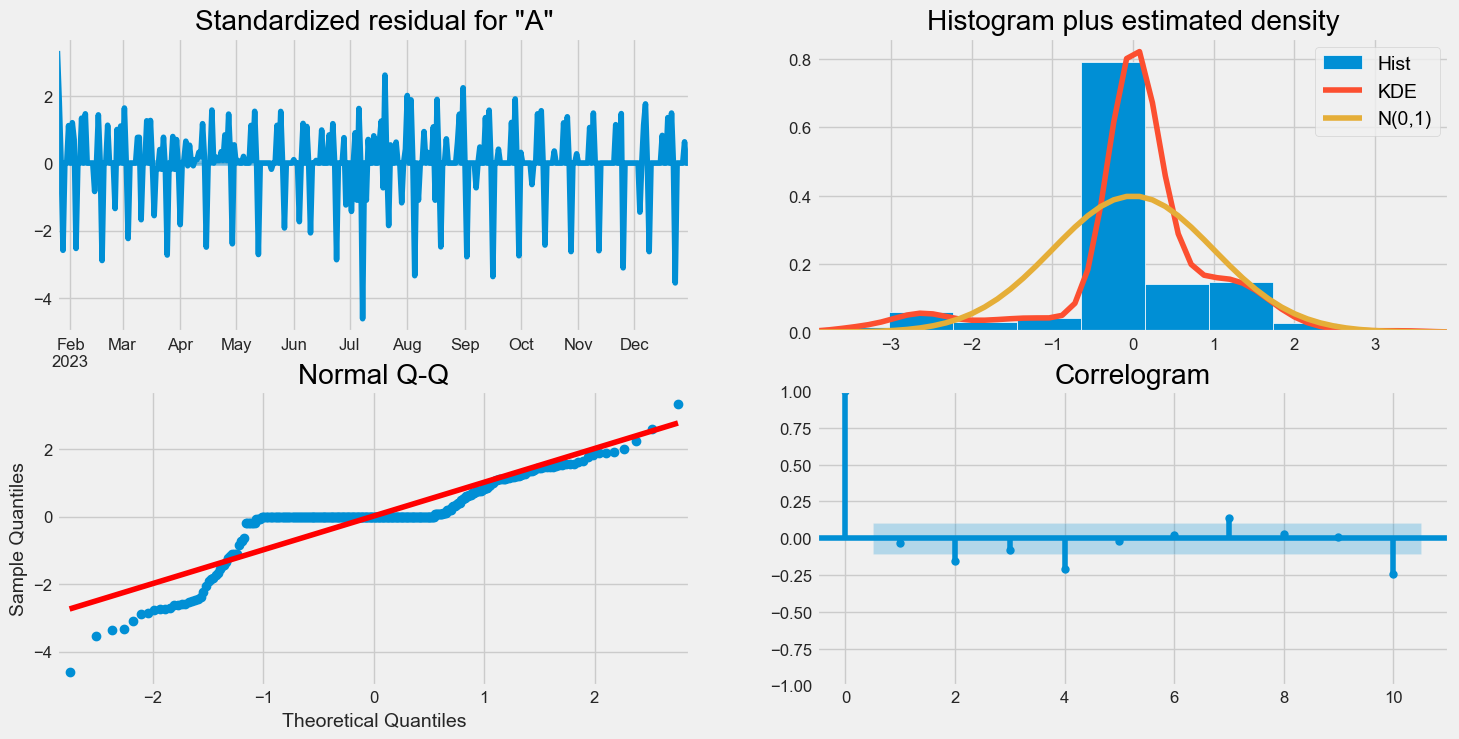

In [135]:
q_food_model1.plot_diagnostics(figsize=(16, 8))
plt.show()

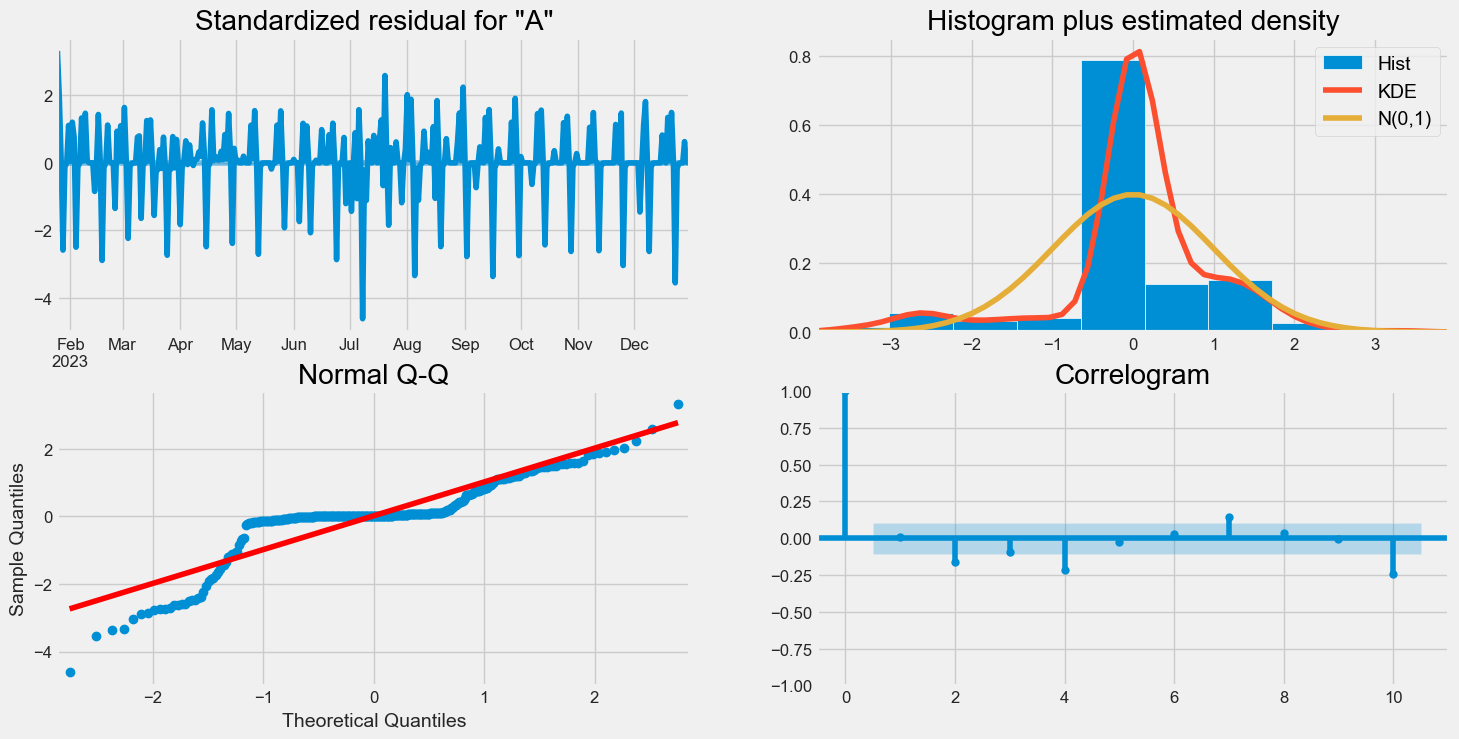

In [136]:
q_food_model2.plot_diagnostics(figsize=(16, 8))
plt.show()

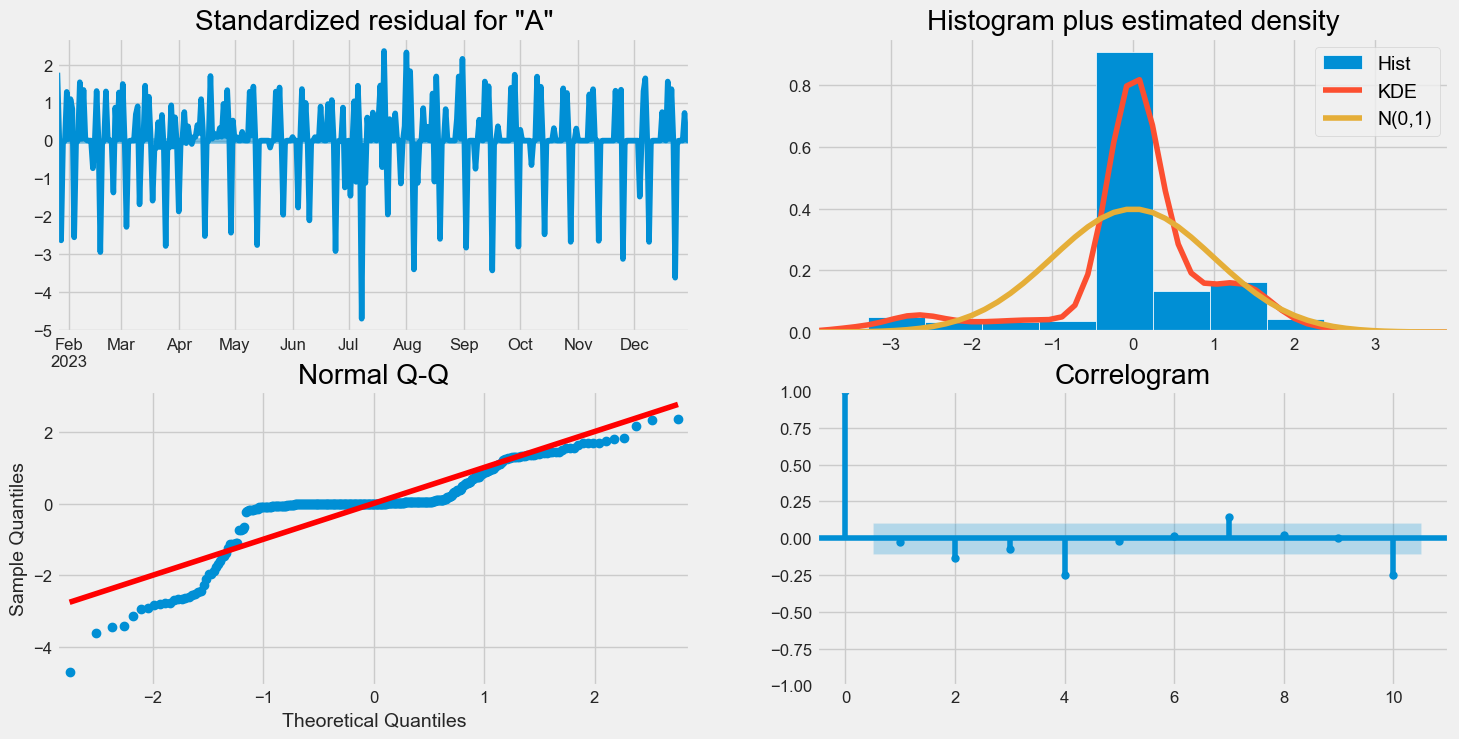

In [137]:
q_food_model3.plot_diagnostics(figsize=(16, 8))
plt.show()

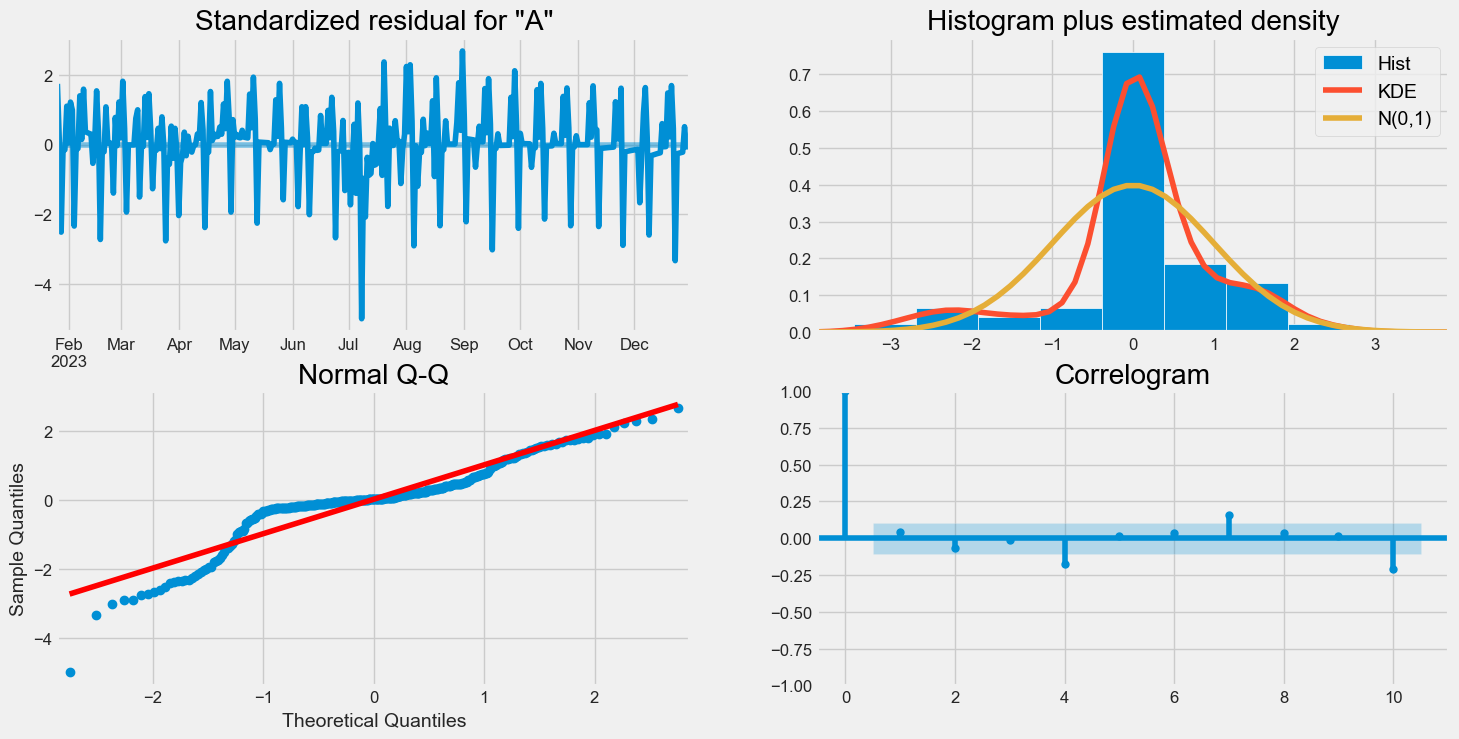

In [138]:
q_food_model4.plot_diagnostics(figsize=(16, 8))
plt.show()

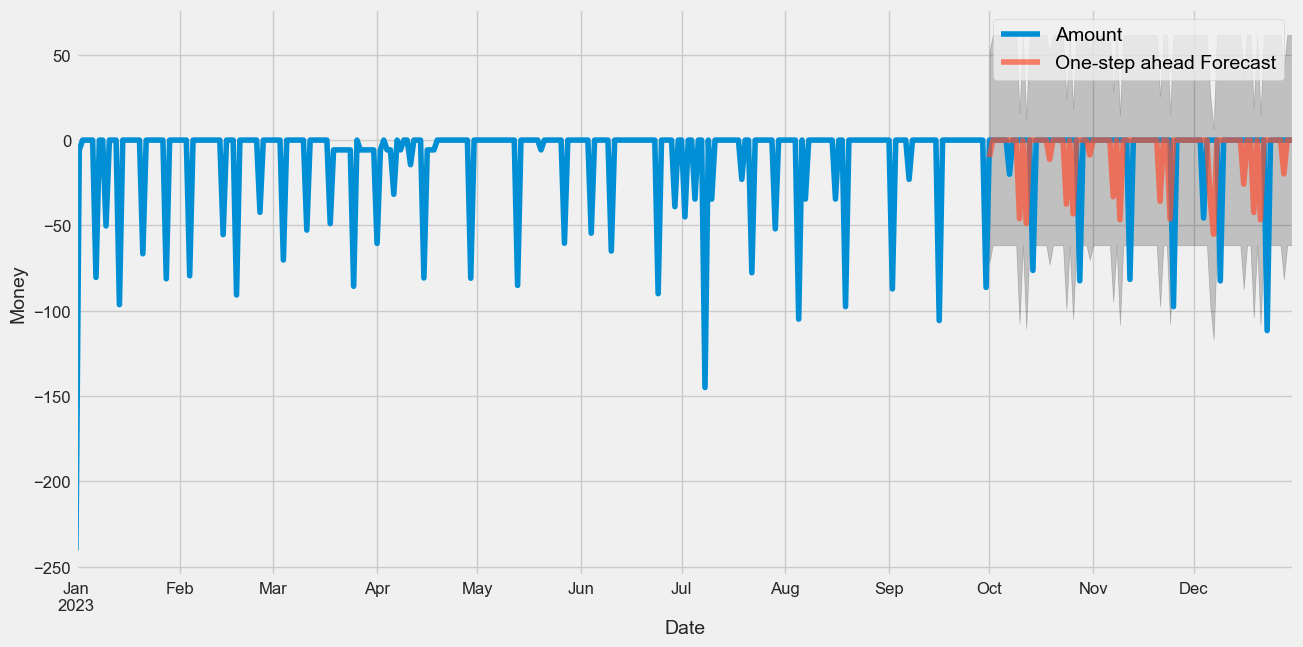

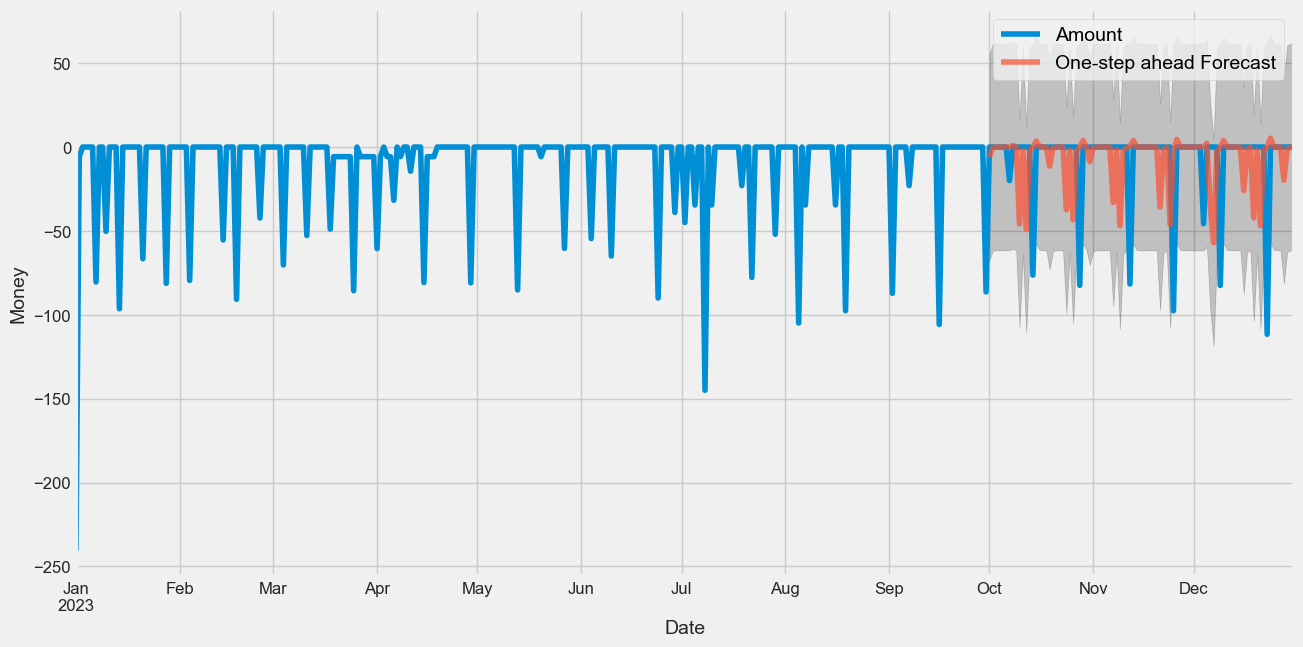

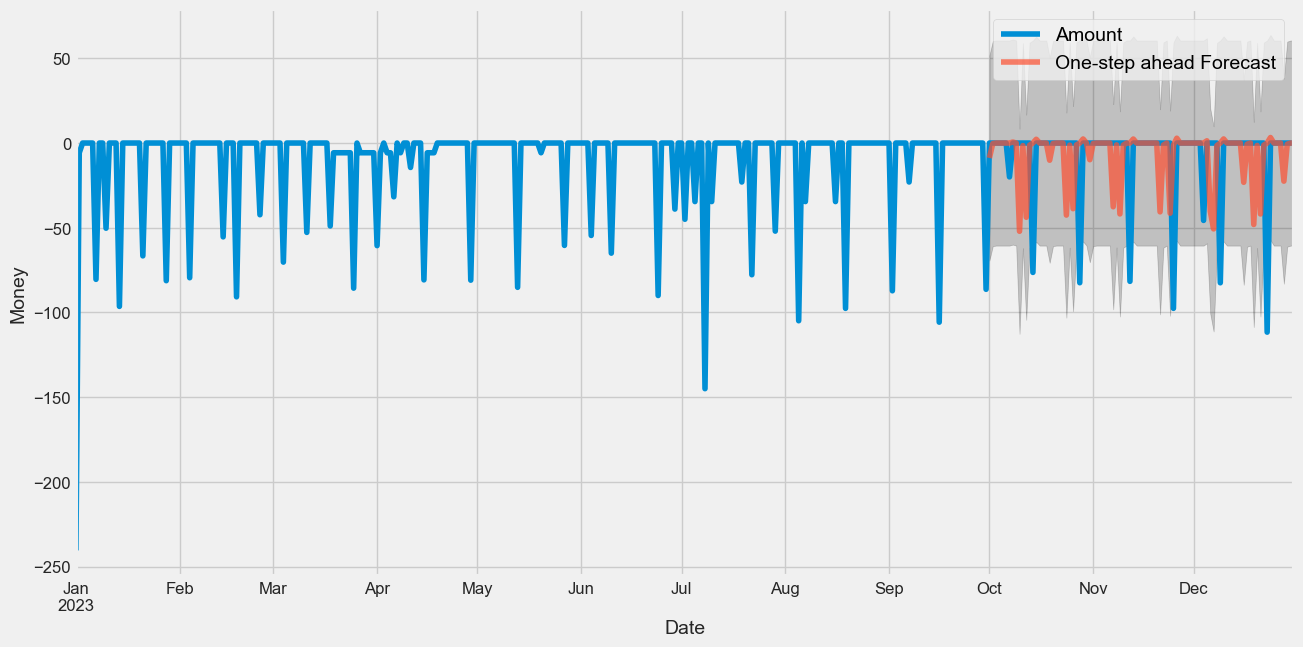

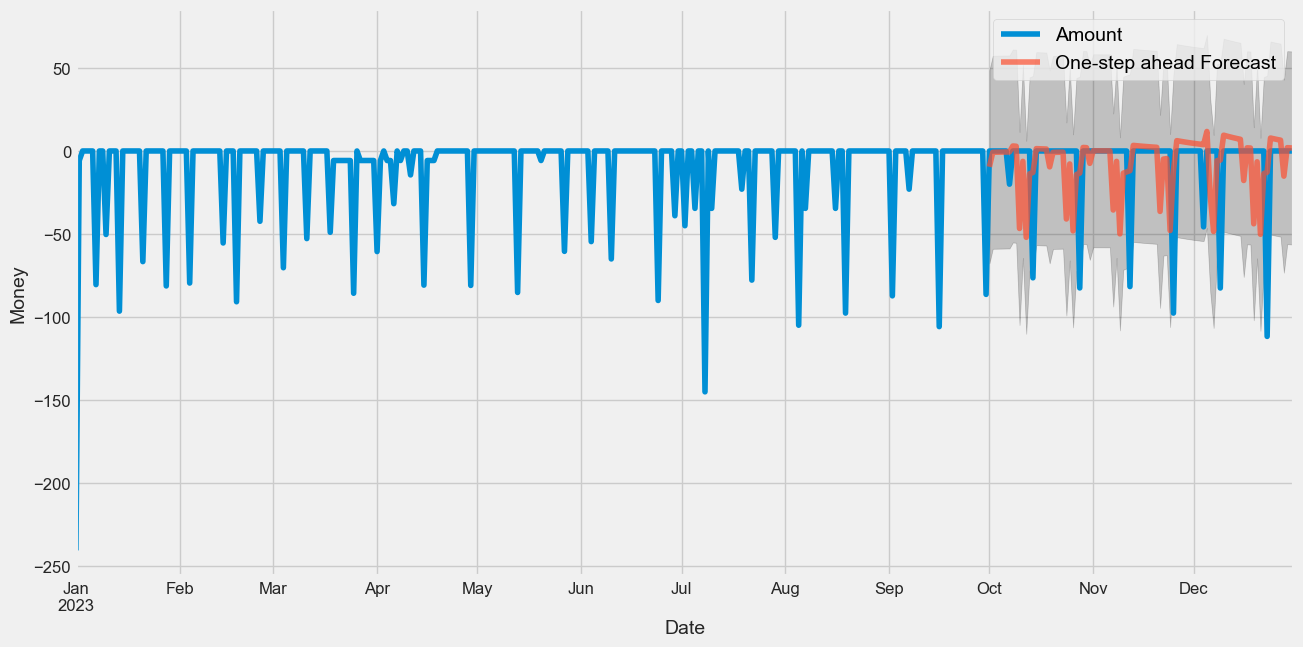

In [139]:
q_oct_forecasted_food1 = predict(q_food_model1, '2023-10-01', prep_food)
q_oct_forecasted_food2 = predict(q_food_model2, '2023-10-01', prep_food)
q_oct_forecasted_food3 = predict(q_food_model3, '2023-10-01', prep_food)
q_oct_forecasted_food4 = predict(q_food_model4, '2023-10-01', prep_food)

In [141]:
rmse(oct_actual_food, q_oct_forecasted_food1)
rmse(oct_actual_food, q_oct_forecasted_food2)
rmse(oct_actual_food, q_oct_forecasted_food3)
rmse(oct_actual_food, q_oct_forecasted_food4)

The Mean Squared Error of our forecasts is 811.66
The Root Mean Squared Error of our forecasts is 28.49
The Mean Squared Error of our forecasts is 809.68
The Root Mean Squared Error of our forecasts is 28.45
The Mean Squared Error of our forecasts is 809.17
The Root Mean Squared Error of our forecasts is 28.45
The Mean Squared Error of our forecasts is 721.01
The Root Mean Squared Error of our forecasts is 26.85


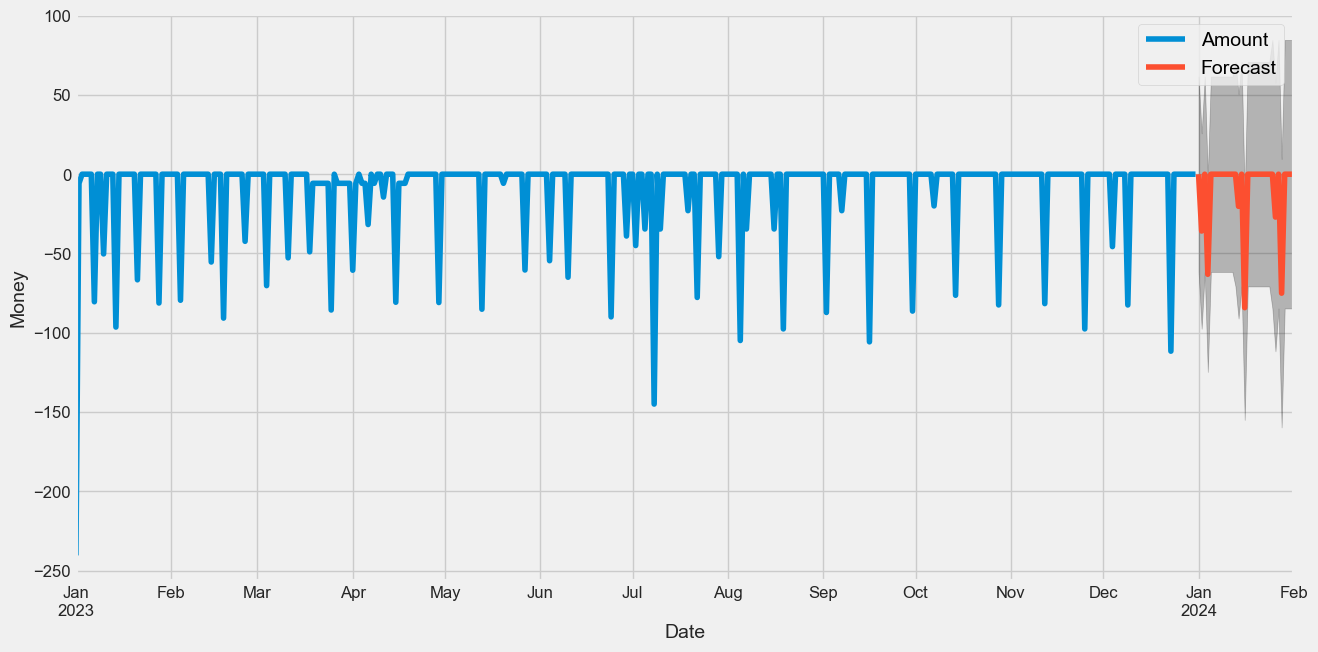

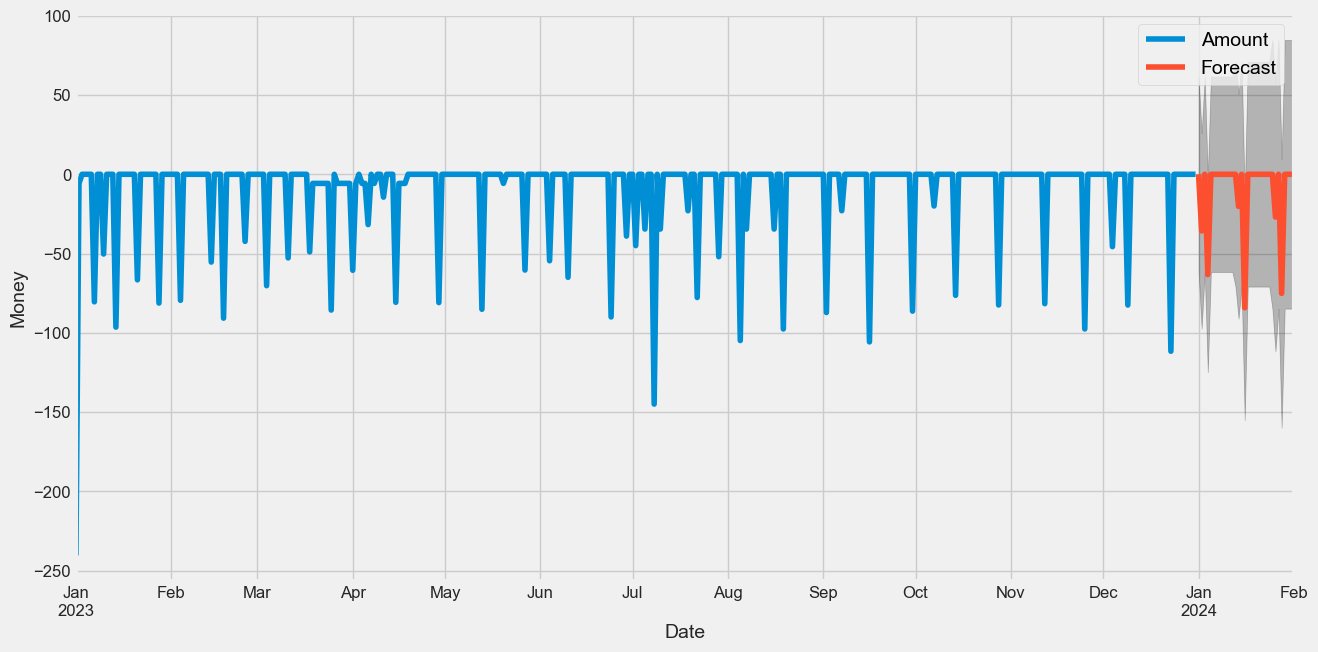

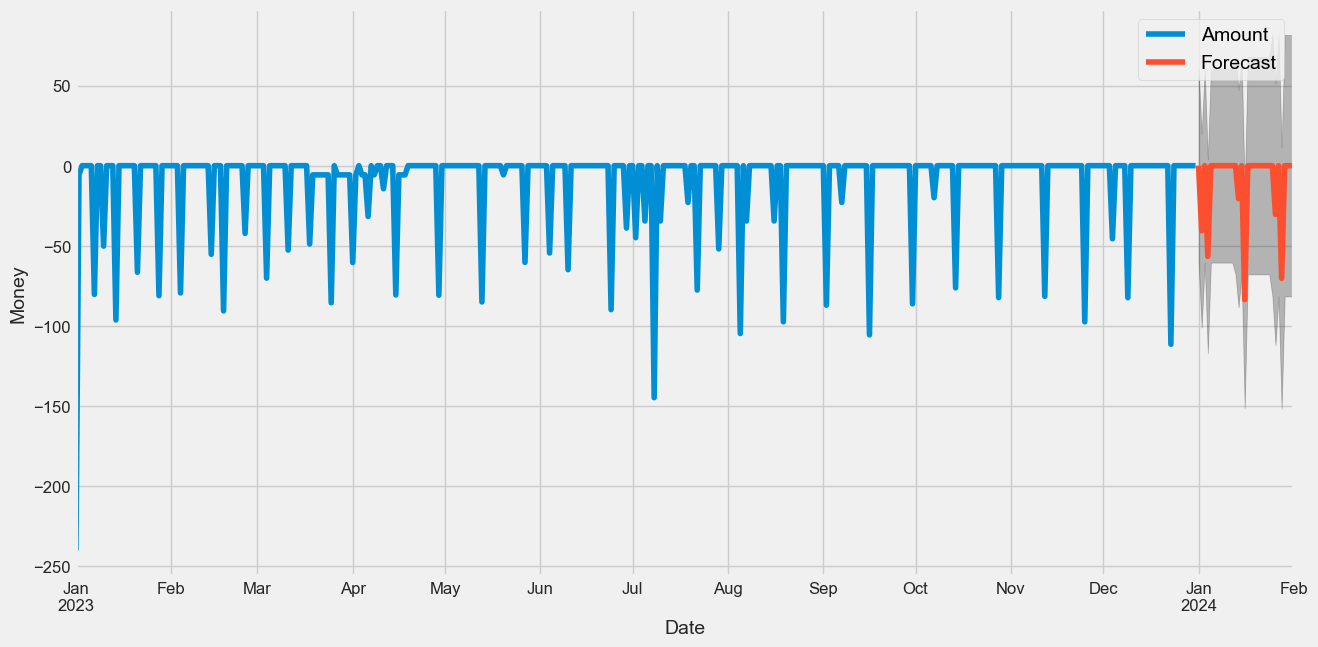

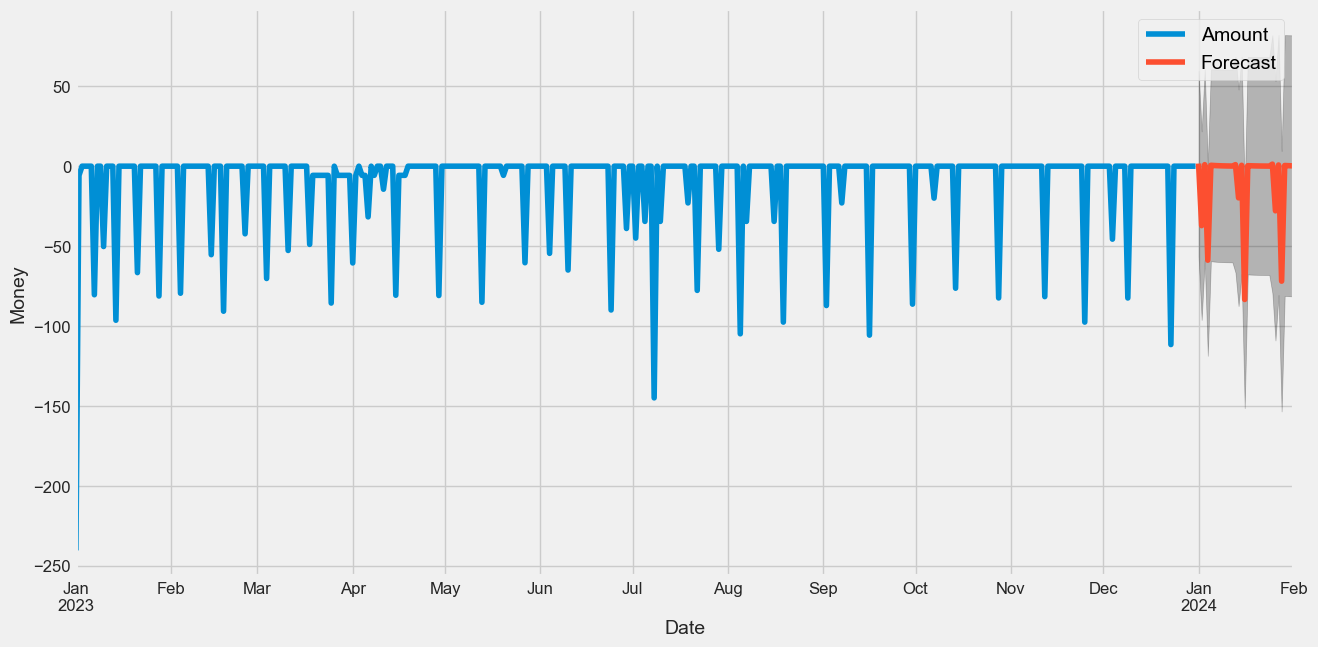

In [142]:
forecast(prep_food, q_food_model1)
forecast(prep_food, q_food_model2)
forecast(prep_food, q_food_model3)
forecast(prep_food, q_food_model4)

# Updating the Model

In [143]:
food_update_df = pd.read_csv('Data/food_update.csv')
food_update_df = food_update_df.loc[food_update_df['Category'] == 'Food & Drinks']
food_update_df.replace(',', '',regex=True, inplace=True)

In [144]:
prep_update = prepare(food_update_df)

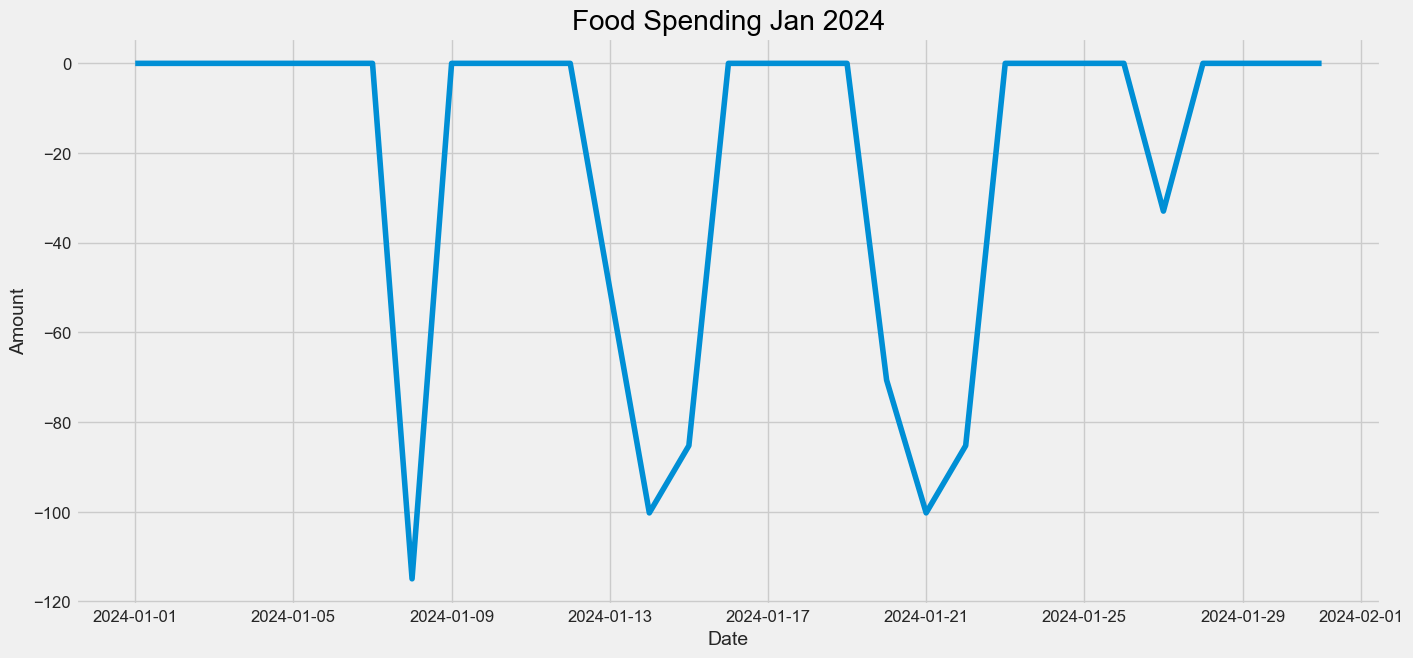

In [145]:
plt.figure(figsize=(15,7))
plt.title("Food Spending Jan 2024")
plt.xlabel('Date')
plt.ylabel('Amount')
plt.plot(prep_update['Amount'])
plt.show()

In [146]:
def incremental_learn(model, dataframe):
    return model.update(dataframe)

In [152]:
updated_food_model = incremental_learn(unfit_food_model, prep_update)